# Polygon around data area

Related to the [Create a polygon with real data extents](https://github.com/agile-geoscience/seisplot/issues/27) issue.

Plan:

1. Make some data.
2. Condition the data into a binary cube.
3. Make a contour around the data area.

## Make some data with lots of nulls

In [111]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats

In [112]:
import os

target = 'data/seismic_data.sgy'

outs = [
    'this/that/other.png',
    '/this/that/other.png',
    'this/that',
    'this/',
    '/this/that',
    '../other.png',
    'other.png',
    '',
    ]

In [113]:
dname, fname, ext = path_bits(target)
def get_outfile(out):
    outfile = out or ''
    if not os.path.splitext(outfile)[1]:
        outfile = os.path.join(out or dname, fname + '.png')
    return outfile

for out in outs:
    print(get_outfile(out))

this/that/other.png
/this/that/other.png
this/that/seismic_data.png
this/seismic_data.png
/this/that/seismic_data.png
../other.png
other.png
data/seismic_data.png


In [115]:
target


'data/seismic_data.sgy'

In [99]:
dirname, fname, ext = path_bits(p)

In [100]:
path_bits(p)

('/this/that', 'other_file', '.txt')

In [97]:
os.path.split(p)

('/this/that', 'other_file.txt')

There's already a small 3D in the `data` directory...

In [2]:
ls ../data

31_81_PR.png       31_81_PR.sgy       F3_very_small.png  F3_very_small.sgy


In [8]:
from obspy.io.segy.segy import _read_segy
#section = _read_segy('../data/F3_very_small.sgy', unpack_headers=True)
section = _read_segy('../data/31_81_PR.sgy', unpack_headers=True)
data = np.stack(t.data for t in section.traces).T
data.shape

(1501, 534)

In [10]:
#cube = np.reshape(data.T, (11, 11, 463))

In [12]:
section.binary_file_header

Binary File Header:
	job_identification_number: 68102153
	line_number: 31
	reel_number: 68102133
	number_of_data_traces_per_ensemble: 1
	number_of_auxiliary_traces_per_ensemble: 0
	sample_interval_in_microseconds: 4000
	sample_interval_in_microseconds_of_original_field_recording: 0
	number_of_samples_per_data_trace: 1501
	number_of_samples_per_data_trace_for_original_field_recording: 0
	data_sample_format_code: 1
	ensemble_fold: 1
	trace_sorting_code: 4
	vertical_sum_code: 1
	sweep_frequency_at_start: 0
	sweep_frequency_at_end: 0
	sweep_length: 0
	sweep_type_code: 0
	trace_number_of_sweep_channel: 0
	sweep_trace_taper_length_in_ms_at_start: 0
	sweep_trace_taper_length_in_ms_at_end: 0
	taper_type: 0
	correlated_data_traces: 0
	binary_gain_recovered: 1
	amplitude_recovery_method: 4
	measurement_system: 0
	impulse_signal_polarity: 0
	vibratory_polarity_code: 0
	unassigned_1: b'\x00\x00\x00\x0c\x00\x01\x00\x00\x17p\x00\x01\x00\x01\x00\x04\x89\x00\x01\x00\x00\x00\x00\x9b\x00\x02\x00\x9f\x00

In [13]:
section.traces[-1].header

trace_sequence_number_within_line: 534
trace_sequence_number_within_segy_file: 534
original_field_record_number: 167
trace_number_within_the_original_field_record: 0
energy_source_point_number: 0
ensemble_number: 634
trace_number_within_the_ensemble: 1
trace_identification_code: 1
number_of_vertically_summed_traces_yielding_this_trace: 1
number_of_horizontally_stacked_traces_yielding_this_trace: 1
data_use: 1
distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group: 0
receiver_group_elevation: 0
surface_elevation_at_source: 0
source_depth_below_surface: 0
datum_elevation_at_receiver_group: 0
datum_elevation_at_source: 0
water_depth_at_source: 0
water_depth_at_group: 0
scalar_to_be_applied_to_all_elevations_and_depths: 0
scalar_to_be_applied_to_all_coordinates: 1
source_coordinate_x: 0
source_coordinate_y: 0
group_coordinate_x: 0
group_coordinate_y: 0
coordinate_units: 0
weathering_velocity: 0
subweathering_velocity: 0
uphole_time_at_source_in_ms: 0
uphole_time_at_gr

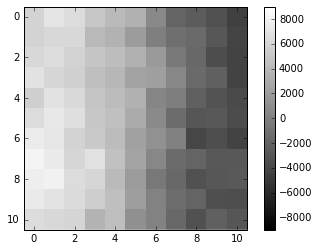

In [7]:
plt.imshow(cube[:,:,200], interpolation='none', cmap="gray", vmin=-9000, vmax=9000)
plt.colorbar()
plt.show()

In [7]:
d = np.hstack([0*cube, cube, 0*cube])

In [8]:
cube = np.vstack([0*d, d, 0*d])

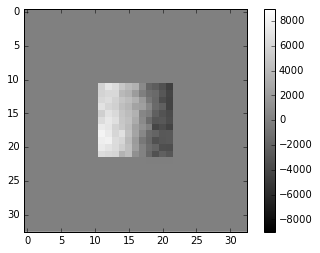

In [9]:
plt.imshow(cube[:,:,200], interpolation='none', cmap="gray", vmin=-9000, vmax=9000)
plt.colorbar()
plt.show()

## Condition the data

First we need to make a binary volume, with 1 where there's live data, 0 where there's only null traces. 

We can do stuff trace by trace and avoid affecting the null data.

In [45]:
all_positive = np.abs(cube)

# Make sure we add enough to ensure a positive number.
all_gt_zero = all_positive[...,:-2] + all_positive[...,1:-1] + all_positive[...,1:-1] + all_positive[...,2:]

flag = np.digitize(all_gt_zero, [0], right=True)

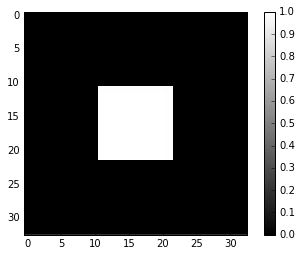

In [46]:
plt.imshow(flag[:,:,200], interpolation='none', cmap="gray")
plt.colorbar()
plt.show()

In [47]:
tslice = flag[:, :, flag.shape[-1]//2]

In [48]:
tslice.shape

(33, 33)

## Contours on image

First, we can make a more complex geometry to test convex hull stuff.

In [50]:
tslice[6:27, 6:27] = 1
tslice[8:13, 10:12] = 0
tslice[14:21, 18:27] = 0
#tslice[14:21, 18:27] = 0

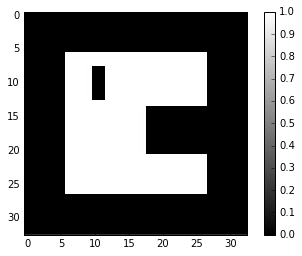

In [53]:
plt.imshow(tslice, interpolation='none', cmap="gray")
plt.colorbar()
plt.show()

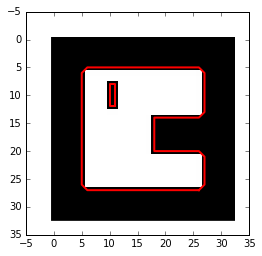

In [54]:
from skimage import measure

# Find contours at a constant value of 0
contours = measure.find_contours(tslice, 0)

# Display the image and plot all contours found
plt.imshow(tslice, interpolation='none', cmap='gray')

for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')

plt.show()

In [86]:
from shapely.geometry import Polygon, MultiPolygon

mpoly = MultiPolygon([Polygon(measure.approximate_polygon(c, 0.01)) for c in contours])

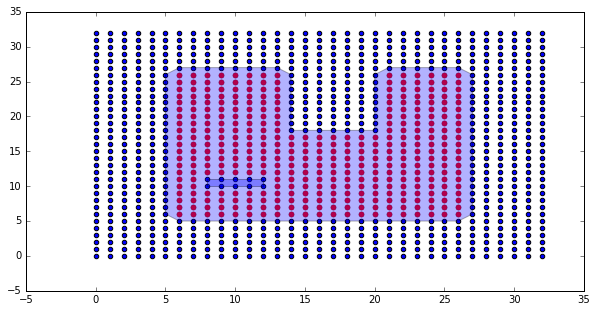

In [89]:
from descartes import PolygonPatch

# Compute all points coordinates for the plot.
all_points = np.array(list(zip(*np.where(tslice < 2))))

# Make the plot.
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(all_points[:,0], all_points[:,1], )
ax.scatter(points[:,0], points[:,1], color='r')

# Make and add the polygon patch.
for p in mpoly:
    patch = PolygonPatch(p, alpha=0.3)
    ax.add_patch(patch)

plt.show()

To make a 'hole', you'd have to use the `symmetric_difference` method:

In [94]:
# Let's erode the outer and dilate the inner while we're about it...
newpoly = mpoly[0].buffer(-0.5).symmetric_difference(mpoly[1].buffer(0.5))

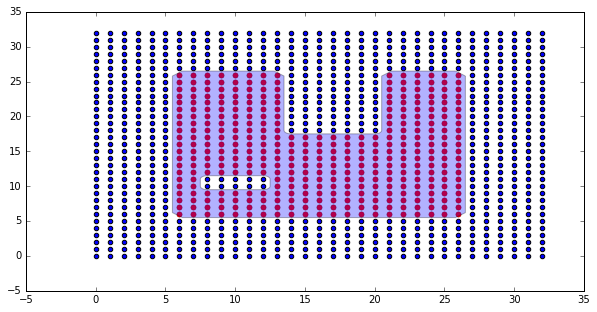

In [95]:
from descartes import PolygonPatch

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(all_points[:,0], all_points[:,1], )
ax.scatter(points[:,0], points[:,1], color='r')

patch = PolygonPatch(newpoly, alpha=0.3)
ax.add_patch(patch)

plt.show()

## `shapely` convex hull

In [55]:
from shapely.geometry import MultiPoint

In [56]:
points = np.array(list(zip(*np.where(tslice == 1))))

In [57]:
mp = MultiPoint(points)

In [58]:
hull = mp.convex_hull

# Optionally buffer the polygon.
hull = hull.buffer(0.5)

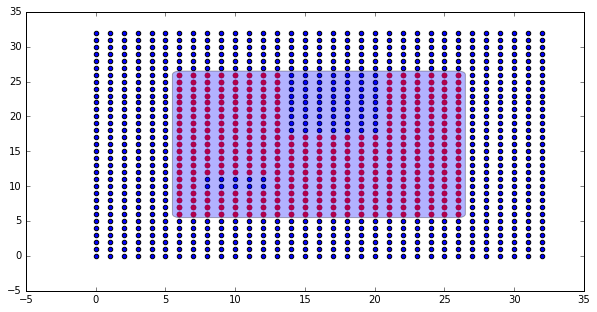

In [71]:
from descartes import PolygonPatch

# Compute all points coordinates for the plot.
all_points = np.array(list(zip(*np.where(tslice < 2))))

# Make the plot.
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(all_points[:,0], all_points[:,1], )
ax.scatter(points[:,0], points[:,1], color='r')

# Make and add the polygon patch.
patch = PolygonPatch(hull, alpha=0.3)
ax.add_patch(patch)

plt.show()